Requirements:

- Numpy
- Pandas
- matplotlib
- sklearn.ensemble
- sklearn.datasets
- sklearn.feature_selection
- sklearn.inspection
- sklearn.model_selection


# Recursive Feature Elimination (RFE)










During the machine learning/deep learning class, we saw that having the ability how to tackle feature selection problematcis was one of the most demanded skills by todays data scientists. 
Many methods were presented during this sessions, such as PCA (Principal Compenent Analysis), t-SNE method and autoencoders. We will now present a new method called the Recursive Feature Elimination.

















## **I - Définitions, principle and theory**


### *1 - Définitions*

We will firstly begin by define each word that the name of the method contains.
    
    
    
Recursive: involving doing or saying the same thing several times in order to produce a particular result or effect    
    
Feature: individual measurable property or characteristic of a phenomenon being observed.

        
RFE method is usually associated with a cross validation method to increase the performances of the algorithm (but also it cost). Cross Validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. Use cross-validation to detect overfitting, ie, failing to generalize a pattern.        


### *2 - Principle*

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_  attribute or through a feature_importances_  attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached. 
[1][2]

In plain words, at first the model is fit on the data. Then we get coefficients giving the importance of each feature by calling a feature_importance attribute. We drop the feature with least coefficient or importance. Then the model is fit on the remaining features. The process is repeated until we have a necessary number of features (or some other criteria is fulfilled).

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                            shuffle=False)
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X, y)


clf.feature_importances_


array([0.16317344, 0.7103684 , 0.06085651, 0.06560165])

The exemple above shows how to get the feature importance array after fitting a model. The variable X horizontally stacks features in the following order: the primary 2 features, followed by 2 features are filled with random noise. As the third and fourth features are only filled with random noise, their feature_importance_coefficient are extremely low compared to others. 

We can then apply the RFE and get the ranking of each feature. As the algorithm stops when the number of features to keep is reached, all the features to keep have a ranking of 1.

In [2]:
from sklearn.feature_selection import RFE


estimator=  RandomForestClassifier(n_estimators = 100)
selector = RFE(estimator, n_features_to_select=2, step=1)
selector = selector.fit(X, y)


selector.ranking_

array([1, 1, 3, 2])

### *3- Theory*

For each estimator, a different method to calculate the feature_importance array is used. For the Random Forest Estimator (The most used estimator for RFE), the most common ones are the GINI importance and the Permutation Importance.

The theory behind those methods are quite easy to understand, as it does not require any mathematic background (contrarely to the Random Forest itself), which explains the short shape of the part.





Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (accross all tress) that include the feature, proportionaly to the number of samples it splits.[2]

Permutation Importance or Mean Decrease in Accuracy (MDA) is assessed for each feature by removing the association between that feature and the target. This is achieved by randomly permuting the values of the feature and measuring the resulting increase in error. The influence of the correlated features is also removed. [4]

The scikit-learn Random Forest Library implements the Gini Importance.

GINI Importance is a lot more fast than the Permutation Importance as it runs in permutations (which makes the algorithm slow) but it is less accurate as it is biased towards certain features. [5]



## *II - The Recursive Feature Elimination*


### 1- Comparaison between the GINI importance and the Permutation Importance

The following example show how to compute the two importances for the boston dataset, which is a boston house-prices dataset already used previously during the ML Class. 

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Text(0.5, 0, 'Random Forest Feature Importance with RandomForestRegressor')

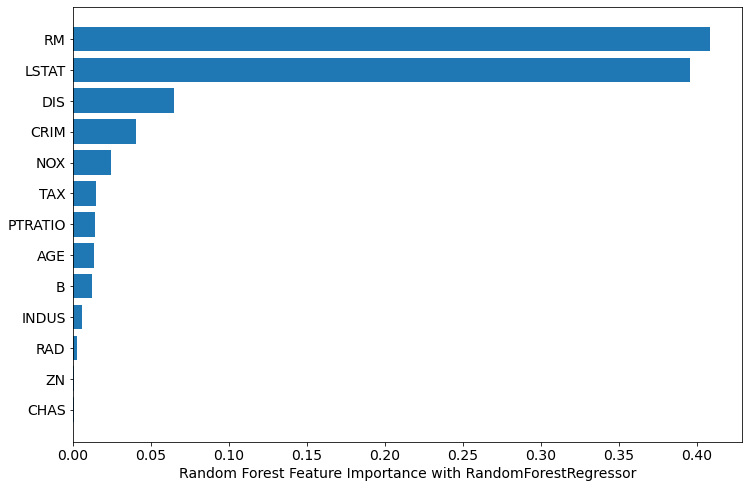

In [4]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(boston.feature_names[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance with RandomForestRegressor")

Text(0.5, 0, 'Permutation Importance')

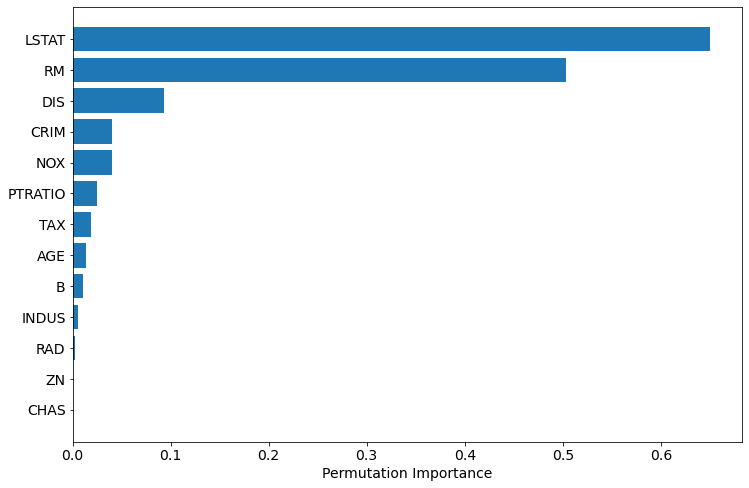

In [5]:
perm_importance = permutation_importance(rf, X, y)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

**Both methods show that the two most important features are LTSTAT and RM, DIS, NOX, CRIM, PTRATIO and AX are also features that we are keen to keep. Even though the two methods lead to the same conclusions, the results are slightly different. A data scientist should know how to tackle this problematics by knowing exactly what is behind the data to be able to choose the best importance criteria between the GINI and the permutation.**

### 2- What is the RFE?

The RFE technique begins by building a model on the entire set of predictors and computing an importance score for each predictor. The least important predictor(s) are then removed, the model is re-built, and importance scores are computed again. In practice, the analyst specifies the number of predictor subsets to evaluate as well as each subset’s size. Therefore, the subset size is a tuning parameter for RFE. The subset size that optimizes the performance criteria is used to select the predictors based on the importance rankings. The optimal subset is then used to train the final model.

### 3- Implementation of the RFE for a simple example

The RFE method already exists in SK Learn, we will apply it for the same example as before: The boston house-prices dataset.

Wall time: 4.41 s


Text(0.5, 1.0, 'Each feature and its ranking. In red the ones to keep')

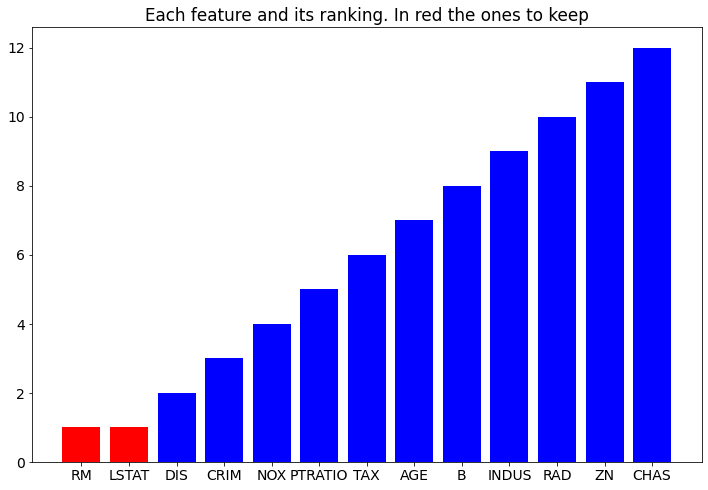

In [6]:

%%time
from sklearn.feature_selection import RFE


estimator=  RandomForestRegressor(n_estimators = 100)
selector = RFE(estimator, n_features_to_select=2, step=1)
selector = selector.fit(X, y)

ranking = dict(zip(X.columns, selector.ranking_))
sorted_ranking = dict(sorted(ranking.items(), key=lambda item: item[1]))

plt.bar(sorted_ranking.keys(), sorted_ranking.values() , color = ['red'  if value == 1 else 'blue' for value in sorted_ranking.values() ] )
plt.title("Each feature and its ranking. In red the ones to keep")

Wall time: 5.42 s


Text(0.5, 1.0, 'Each feature and its ranking. In red the ones to keep')

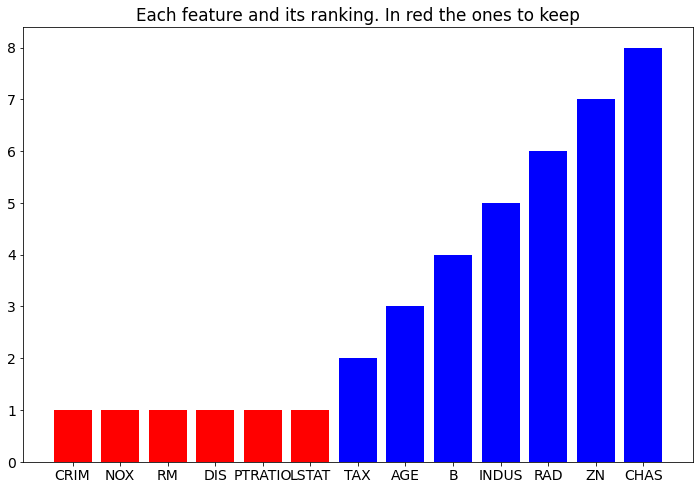

In [7]:
%%time


estimator=  RandomForestRegressor(n_estimators = 100)
selector = RFE(estimator, n_features_to_select=6, step=1)
selector = selector.fit(X, y)

ranking = dict(zip(X.columns, selector.ranking_))
sorted_ranking = dict(sorted(ranking.items(), key=lambda item: item[1]))

plt.bar(sorted_ranking.keys(), sorted_ranking.values() , color = ['red'  if value == 1 else 'blue' for value in sorted_ranking.values() ] )
plt.title("Each feature and its ranking. In red the ones to keep")

Wall time: 2.42 s


Text(0.5, 1.0, 'Each feature and its ranking. In red the ones to keep')

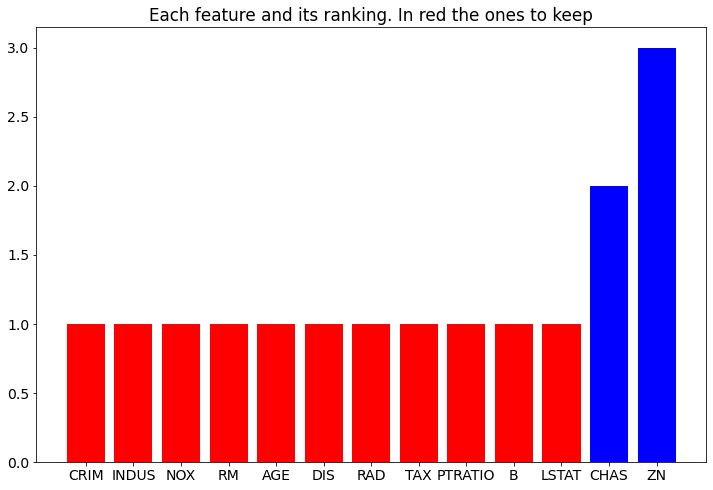

In [8]:
%%time


estimator=  RandomForestRegressor(n_estimators = 100)
selector = RFE(estimator, n_features_to_select=11, step=1)
selector = selector.fit(X, y)

ranking = dict(zip(X.columns, selector.ranking_))
sorted_ranking = dict(sorted(ranking.items(), key=lambda item: item[1]))

plt.bar(sorted_ranking.keys(), sorted_ranking.values() , color = ['red'  if value == 1 else 'blue' for value in sorted_ranking.values() ] )
plt.title("Each feature and its ranking. In red the ones to keep")

We can notice that the less features we want to keep, the more the algoithm takes time. It goes whith what we were expecting considering the behaviour of the algorithm as it eliminates features one by one. 

In the following part, we will perform the RFE method and check if the score obtained after our prediction with less features than the original dataset is still satisfying or not.

Text(0.5, 1.0, 'Importance of each feature')

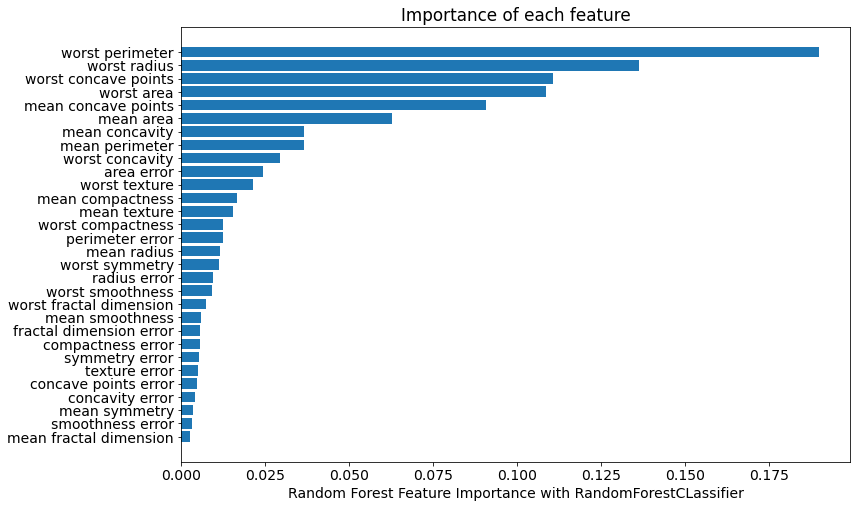

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance with RandomForestCLassifier")
plt.title("Importance of each feature")


We first create the dataset containing only 3 features selected with the RFE.

In [10]:
%%time

estimator=  RandomForestRegressor(n_estimators = 100)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X, y)


myDict = {key:val for key, val in (dict(zip(X.columns,selector.ranking_))).items() if val ==1}

X_3_train = X_train[list(myDict.keys())]
X_3_test = X_test[list(myDict.keys())]



Wall time: 17.6 s


Then ,we create the dataset containing 8 features.

In [11]:
estimator=  RandomForestRegressor(n_estimators = 100)
selector = RFE(estimator, n_features_to_select=8, step=1)
selector = selector.fit(X, y)


myDict = {key:val for key, val in (dict(zip(X.columns,selector.ranking_))).items() if val ==1}

X_8_train = X_train[list(myDict.keys())]
X_8_test = X_test[list(myDict.keys())]

In [12]:


rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print("The score when keeping all the features is:" , round(rf.score(X_test,y_test),6))

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_8_train, y_train)
print("The score when keeping the 8 features with biggest feature_importance:" , round(rf.score(X_8_test,y_test),6))

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_3_train, y_train)
print("The score when keeping the 3 features with biggest feature_importance:" , round(rf.score(X_3_test,y_test),6))


The score when keeping all the features is: 0.964912
The score when keeping the 8 features with biggest feature_importance: 0.964912
The score when keeping the 3 features with biggest feature_importance: 0.95614


The scores differ slightly, hence it shows the power of the RFE. By keeping only 3 features, we reach the same score as if we kept them all. 

Those remarks were conducted after performing a test_train_split to our dataset. Maybe using a cross validation will be a lot more accurate in our case. Even better, a grid search to get directly the number of features that allows us to get the maximum scoring.

Hopefully, this function already exists in SK-learn, it is the RFECV (Recursive feature Elimination with Cross Validation).

## III- The Recursive Feature Elimination with Cross Validation ##

### 1- What is it?

RFECV is basically feature ranking with recursive feature elimination and cross-validated selection of the best number of features. It is as simple as that. [3]

### 2- RFECV for a simple example ###

We will perform RFECV for a simple dataset generated with the make_classification method. As we declare 6 informative features and 5 "noise features", we except to get the best score for 6 features kept.

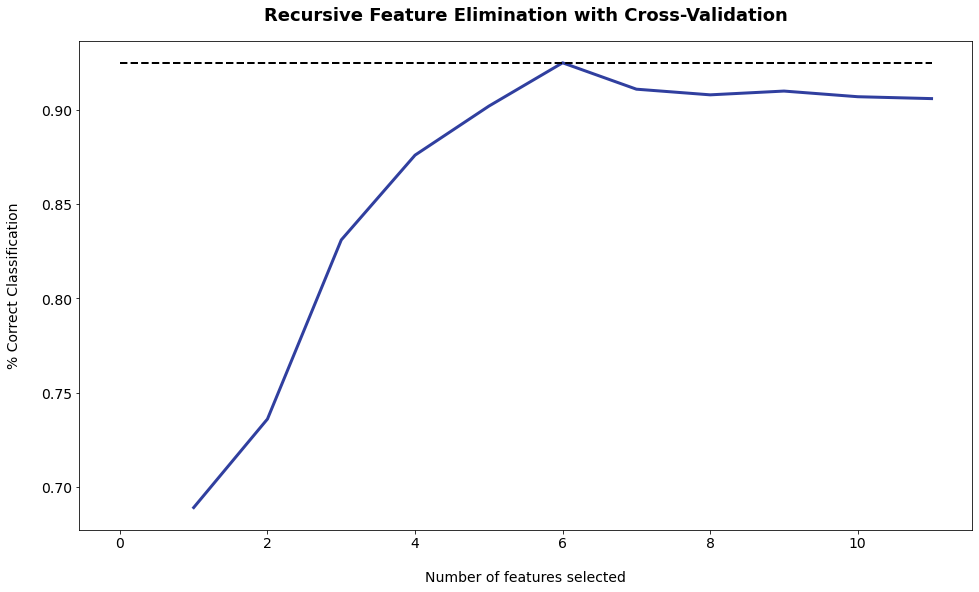

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X, y = make_classification(n_samples=1000, n_features=11,
                           n_informative=6, n_redundant=0,
                           random_state=0, shuffle=False)
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, y)

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.plot([0, X.shape[1]], [rfecv.grid_scores_.max(), rfecv.grid_scores_.max()], 'k--', lw=2)


plt.show()

As expected, we get the maximum score for 6 features. The big issue with that method is that it is extremely time consuming. 
This characteristic will appear when performing the RFECV for a larger dataset, the breast_cancer dataset.

### 3- RFECV for the breast_cancer dataset ###

Optimal number of features: 19
Best score: 0.973684


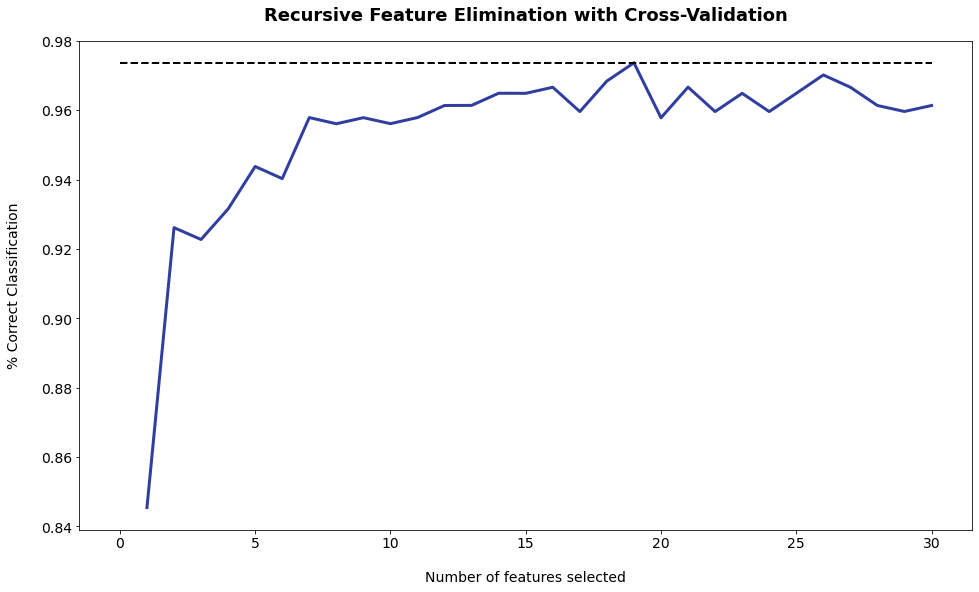

Wall time: 2min 6s


In [14]:
%%time

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

rfc = RandomForestClassifier(n_estimators = 100 ,random_state = 100)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, y)

print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Best score:' , round(rfecv.grid_scores_.max(),6))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.plot([0, X.shape[1]], [rfecv.grid_scores_.max(), rfecv.grid_scores_.max()], 'k--', lw=2)
plt.show()

It took us 2 min 6s to compute the results of the RFECV, which is not viable at all.
The very first idea to think of is to use a less time consuming estimator, such as the Naive Baise Claissifier which has an extremely cheap complexity compared to RandomForest. 

The problem is that you will face a problem when getting the error ("This estimator does not have a coeff_ or feature_importance_ attribute"). There are only few estimators capable of giving such an information, the RandomForest and the SVM are part of them.

Is it better to use the soft version of RFECV which is RFE? Is it better to turn completely our back to RFE and chose another algorithm for feature selection such as the Sequential Feature Selector?

It is difficult to answer withtout possessing the data.
But if you want to use RFE (or even  RFECV) in an optimal way, here are the steps to follow.

## IV - Steps to follow ##

During this part, we will use the breast_cancer dataset.

In [15]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

X.shape

(569, 30)

### 1- Remove the correlated variables ###

The main issue of RFE is that it can be expensive to run — so you should do anything you can to reduce the number of features beforehand. Removing correlated features is a great way to do so because as you probably know, you don’t want highly correlated features in your dataset because they provide the same information — one is enough.
To address this you could plot a correlation matrix and then write down which features are correlated are remove them by hand, but as always, there is a smarter way. I’ve decided to share a simple snippet with you which will check which features have the correlation coefficient above 0.9.

In [16]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
list(correlated_features)

['worst perimeter',
 'worst concave points',
 'worst texture',
 'mean concave points',
 'mean area',
 'worst radius',
 'worst area',
 'perimeter error',
 'mean perimeter',
 'area error']

In [17]:
X_new = X.drop(columns = list(correlated_features))
X_new.shape

(569, 20)

### 2- Apply an RFECV

Optimal number of features: 9
Best score: 0.959586


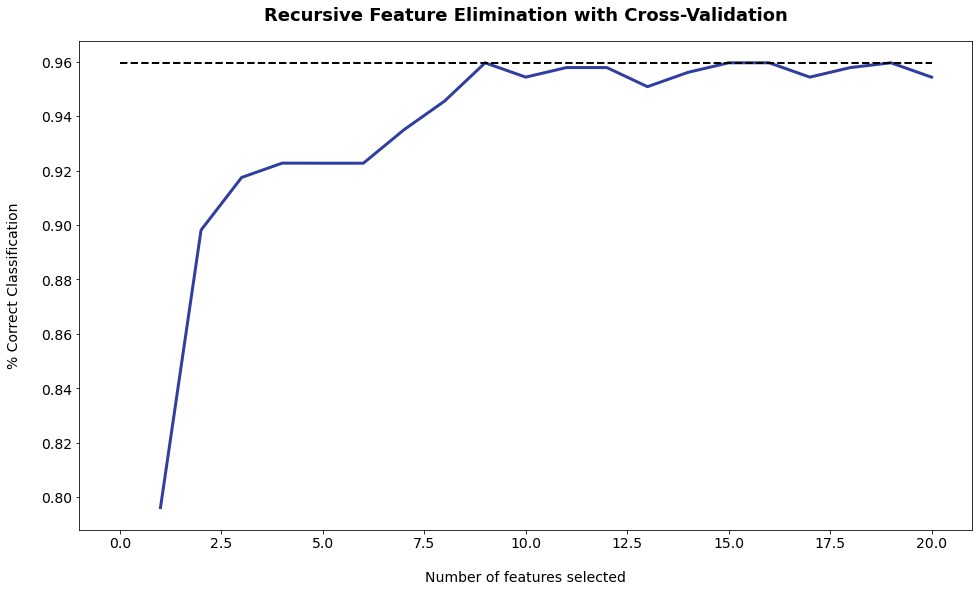

Wall time: 1min 24s


In [18]:
%%time

rfc = RandomForestClassifier(n_estimators = 100)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_new, y)

print('Optimal number of features: {}'.format(rfecv.n_features_))
print('Best score:' , round(rfecv.grid_scores_.max(),6))


plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.plot([0, X_new.shape[1]], [rfecv.grid_scores_.max(), rfecv.grid_scores_.max()], 'k--', lw=2)


plt.show()

By removing the correlated features, we save 30% of the time of runnin, without losing a lot of precision. We can also try a simple RFE if the dataset is extremely large.

### 3- If it takes too much time, conduct a simple RFE

We first start by calculating the feature importance to find out how many features it is optimal to keep (the more we keep, the fastest the RFE will be). 

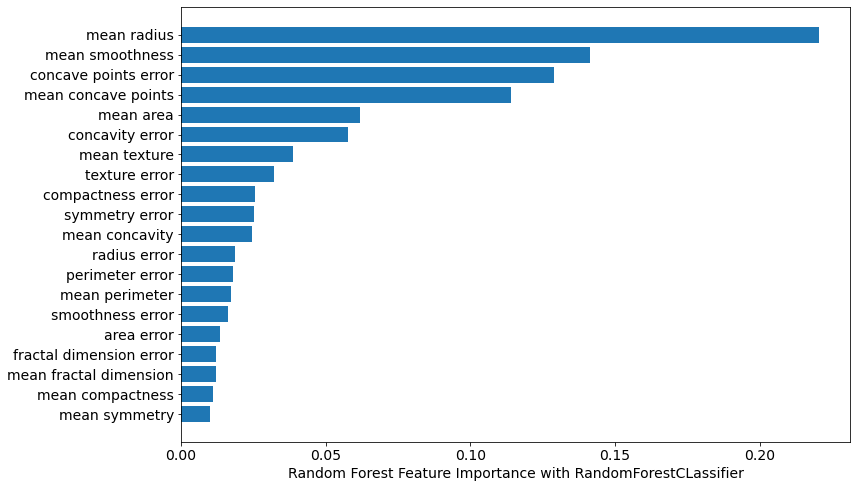

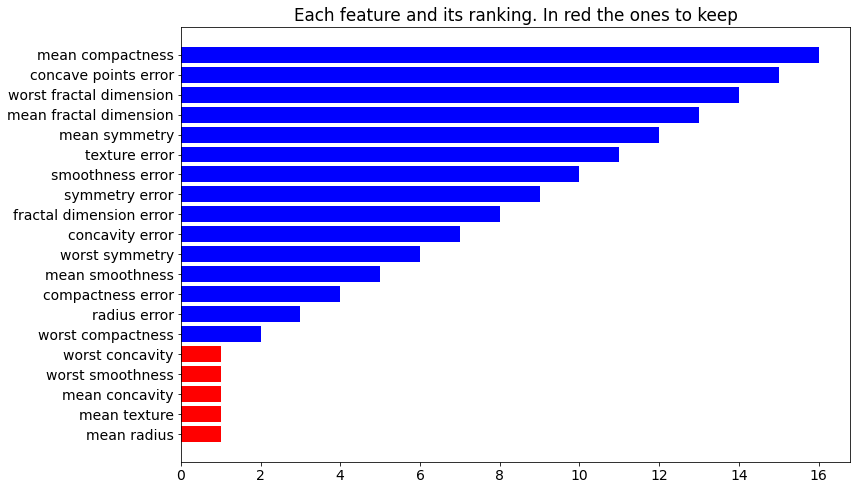

The score when keeping the 6 features with biggest feature_importance: 0.973684
Wall time: 11.2 s


In [19]:
%%time

X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_new, y)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance with RandomForestCLassifier")
plt.show()



estimator=  RandomForestRegressor(n_estimators = 100)
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_new, y)
myDict = {key:val for key, val in (dict(zip(X.columns,selector.ranking_))).items() if val ==1}

X_6_train = X_train[list(myDict.keys())]
X_6_test = X_test[list(myDict.keys())]

ranking = dict(zip(X_new.columns, selector.ranking_))
sorted_ranking = dict(sorted(ranking.items(), key=lambda item: item[1]))

plt.barh(list(sorted_ranking.keys()),list(sorted_ranking.values()),
            color = ['red'  if value == 1 else 'blue' for value in sorted_ranking.values() ])
plt.title("Each feature and its ranking. In red the ones to keep")
plt.show()


rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_6_train, y_train)
print("The score when keeping the 6 features with biggest feature_importance:" , round(rf.score(X_6_test,y_test),6))




It is a lot more faster than the RFECV but less accurate as no cross validation is performed and the number of features to keep is chosen by us.

## Conclusion

RFE certainly isn’t the only feature selection method to use, but it’s one of them, and I certainly feel like it isn’t getting as much attention as it should.

By combining RFE (and RFVEC) with removing the correlated features, we noticed that we succeeded to speed the algorithm without losing much in accuracy. We can then think about combining RFE with other algorithms of dimensionality reduction.

We can think about combining PCA and RFE. How does it work?
Should we apply RFE to the new features obtained by PCA? Is it rational as PCA already gives us the importance of each new feature?

Those are definitely questions that are being asked in todays research wolrd as we can see in the article [8], where the researches ended up by speeding up a multi class SVM by combining PCA and RFE.

[1] https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

[2] https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-10-213

[3] https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15

[4] https://towardsdatascience.com/the-3-ways-to-compute-feature-importance-in-the-random-forest-96c86b49e6d4

[5] https://towardsdatascience.com/a-relook-on-random-forest-and-feature-importance-2467dfab5cca

[6] https://alexisperrier.com/datascience/2015/08/27/feature-importance-random-forests-gini-accuracy.html

[7] https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3#:~:text=Gini%20Importance%20or%20Mean%20Decrease%20in%20Impurity%20(MDI)%20calculates%20each,number%20of%20samples%20it%20splits.

[8] https://www.researchgate.net/publication/248578125_Speeding_Up_Multi-class_SVM_Evaluation_by_PCA_and_Feature_Selection